# Results


In [2]:
%matplotlib inline
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, '..')
from utils import plot_stroke

from utils.constants import Global
from utils.dataset import HandwritingDataset
from utils.data_utils import data_denormalization, data_normalization, valid_offset_normalization
from models.models import HandWritingPredictionNet, HandWritingSynthesisNet
from generate import generate_unconditional_seq, generate_conditional_sequence

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'

### Unconditional generation:

seed: 224
Generating sequence....


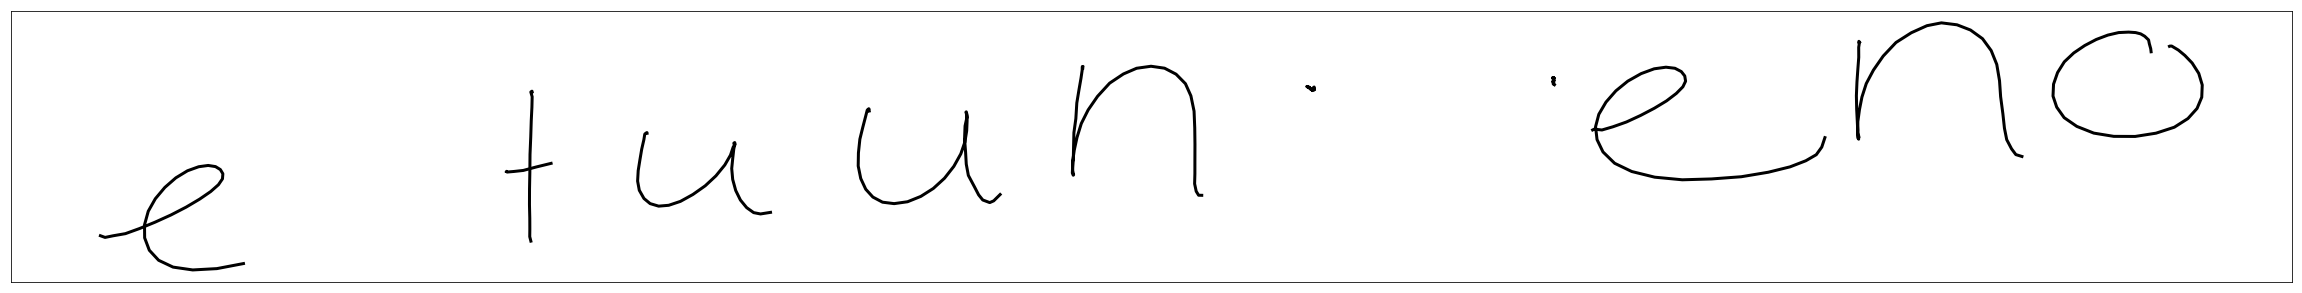

In [56]:
seed = 224
if seed:
    print("seed:",seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
model_path = '../results/best_model_prediction.pt'

train_dataset = HandwritingDataset(data_path, split='train', text_req=False)

seq_len = 400
#prediction
gen_seq = generate_unconditional_seq(model_path, seq_len, device, bias=10., style=None, prime=False)

# denormalize the generated offsets using train set mean and std
gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)

# plot the sequence
plot_stroke(gen_seq[0])

### Unconditional priming

seed: 224
Prime style index:  1920
begining there. If there is any
torch.Size([1, 547, 3])
Generating sequence....


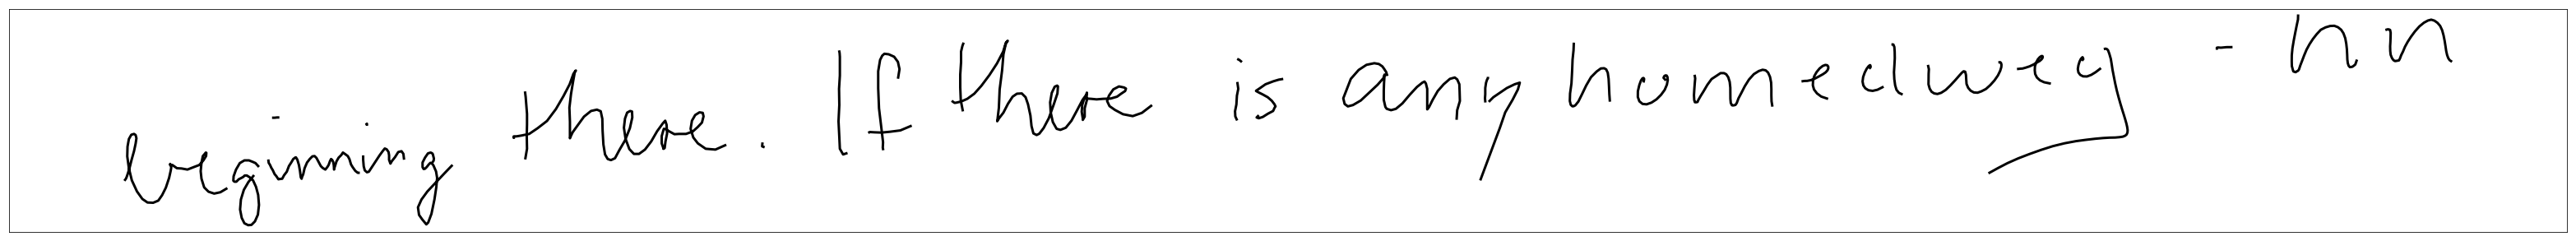

In [143]:
seed = 224
if seed:
    print("seed:",seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
model_path = '../results/best_model_prediction.pt'

train_dataset = HandwritingDataset(data_path, split='train', text_req=False)

seq_len = 400
prime = True
bias = 10.
# file_path = '../app/'
file_path = None
if prime and file_path:
    style = np.load(file_path + 'style.npy', allow_pickle=True, encoding='bytes').astype(np.float32)
    with open(file_path + 'inpText.txt') as file:
        texts = file.read().splitlines()
    real_text = texts[0]
    # plot the sequence
    plot_stroke(style, save_name="style.png")
    print(real_text)
    mean, std, _ = data_normalization(style)
    style = torch.from_numpy(style).unsqueeze(0).to(device)
    print(style.shape)
elif prime:
    strokes = np.load(data_path + 'strokes.npy',
                      allow_pickle=True, encoding='bytes')
    with open(data_path + 'sentences.txt') as file:
        texts = file.read().splitlines()
    idx = np.random.randint(0, len(strokes))
    print("Prime style index: ", idx)
    real_text = texts[idx]
    style = strokes[idx] 
    # plot the sequence
    plot_stroke(style, save_name="style_" + str(idx) + ".png")
    print(real_text)
    mean, std, _ = data_normalization(style)
    style = torch.from_numpy(style).unsqueeze(0).to(device)
    print(style.shape)
    
#prediction
gen_seq = generate_unconditional_seq(model_path, seq_len, device, bias, style, prime)

# denormalize the generated offsets using train set mean and std
gen_seq = data_denormalization(mean, std, gen_seq)

# plot the sequence
plot_stroke(gen_seq[0])

### Conditional generation:

Vocab size:  77
python handwriting synthesis  
Generating sequence....
EOS: True
seq_len: 803
Input seq:  python handwriting synthesis  
Length of input sequence:  30


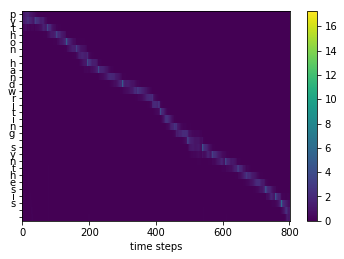

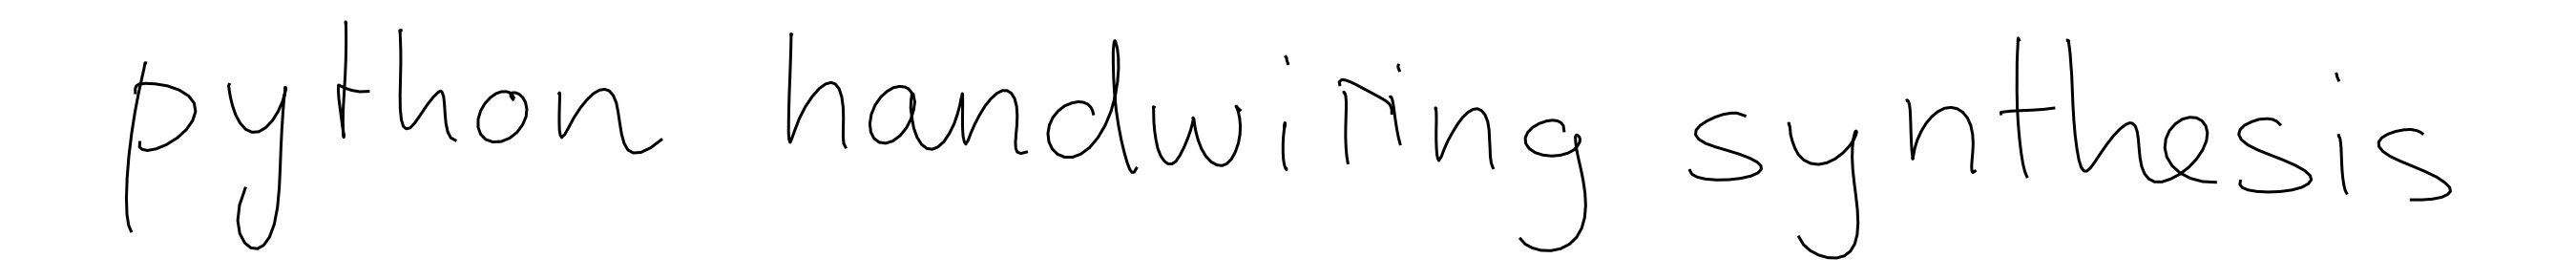

In [14]:
# seed = 128
# if seed:
# print("seed:",seed)
#     torch.manual_seed(seed)
#     np.random.seed(seed)
model_path = '../results/best_model_synthesis.pt'

train_dataset = HandwritingDataset(data_path, split='train', text_req=True)
# print(train_dataset.char_to_id)
# print(train_dataset.id_to_char)
# print(train_dataset.idx_to_char(np.arange(26,32)))
char_seq = "python handwriting synthesis"
bias = 10.
is_map = True
ytext = char_seq + "  "


gen_seq, phi = generate_conditional_sequence(
        model_path, char_seq, device, train_dataset.char_to_id,
        train_dataset.idx_to_char, bias, prime=False, prime_seq=None, real_text=None, is_map=is_map)
if is_map:
    plt.imshow(phi, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel("time steps")
    plt.yticks(np.arange(phi.shape[0]), list(ytext), rotation='horizontal')
    plt.margins(0.2)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)

# plot the sequence
plot_stroke(gen_seq[0])

### Conditional priming using style from training data:

Prime style index:  345


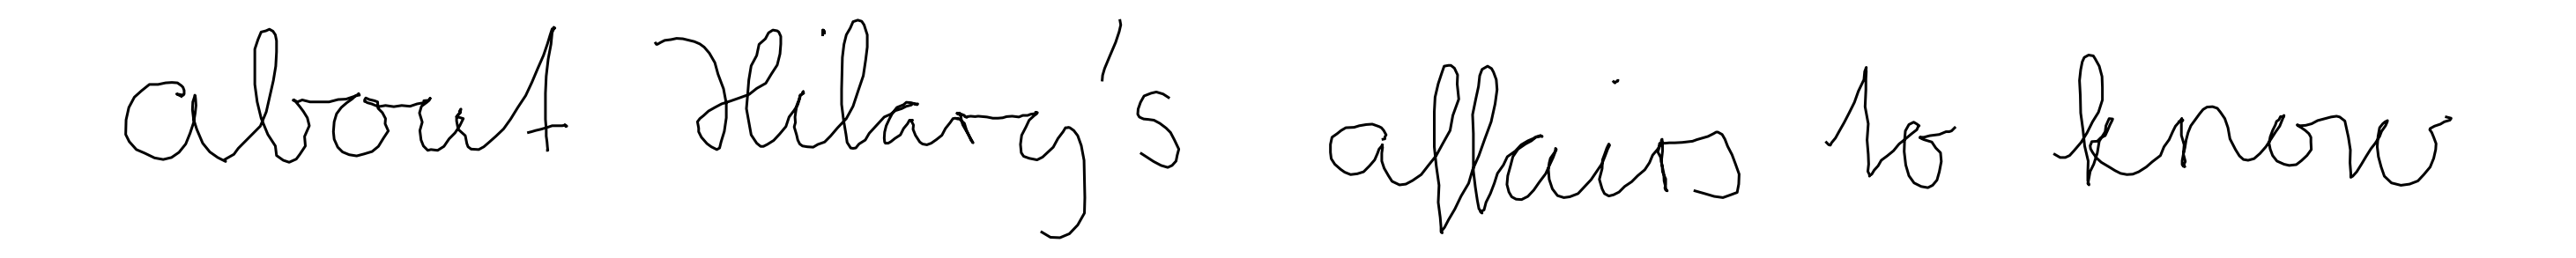

Priming text:  about Hilary's affairs to know
Priming sequence size:  torch.Size([1, 1050, 3])
Vocab size:  77
about Hilary's affairs to know using recurrent neural network  
Generating sequence....
EOS: True
seq_len: 957
Input seq:  about Hilary's affairs to know using recurrent neural network  
Length of input sequence:  63


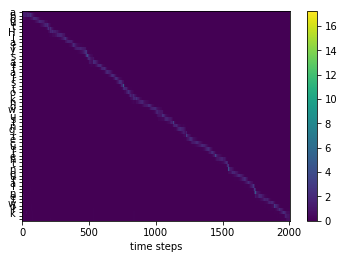

data denormalization...


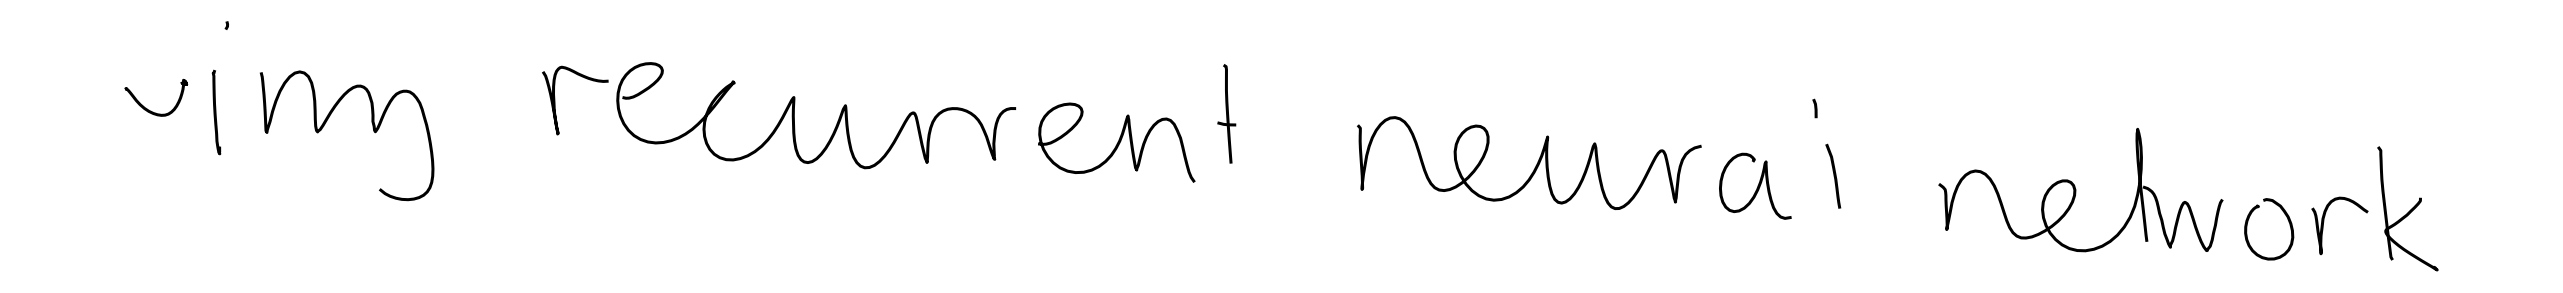

In [92]:
# seed = 218#196 198 200 216 218 220 232 241 262 266 288 290 302
# if seed:
#     print("seed:",seed)
#     torch.manual_seed(seed)
#     np.random.seed(seed)
    
prime = True
bias = 6.
char_seq = "using recurrent neural network"
is_map = True

strokes = np.load(data_path + 'strokes.npy',
                          allow_pickle=True, encoding='bytes')
with open(data_path + 'sentences.txt') as file:
    texts = file.read().splitlines()
    
idx = 345#np.random.randint(0, len(strokes))
print("Prime style index: ", idx)
real_text = texts[idx]
style = strokes[idx] 
# plot the sequence
plot_stroke(style)
print("Priming text: ", real_text)

mean, std, style = data_normalization(style)
style = torch.from_numpy(style).unsqueeze(0).to(device)

# style = valid_offset_normalization(Global.train_mean, Global.train_std, style[None,:,:])
# style = torch.from_numpy(style).to(device)
print("Priming sequence size: ", style.shape)

ytext = real_text + ' ' + char_seq + "  " 

gen_seq, phi = generate_conditional_sequence(
            model_path, char_seq, device, train_dataset.char_to_id,
            train_dataset.idx_to_char, bias, prime, style, real_text, is_map)
if is_map:
    plt.imshow(phi, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel("time steps")
    plt.yticks(np.arange(phi.shape[0]), list(ytext), rotation='horizontal')
    plt.margins(0.2)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# denormalize the generated offsets using train set mean and std
print("data denormalization...")
gen_seq = data_denormalization(Global.train_mean, Global.train_std, gen_seq)
# plot the sequence
plot_stroke(gen_seq[0])

### Conditional priming using unseen style:

[  0.  -4. -18.]
[ 1. 31. 50.]


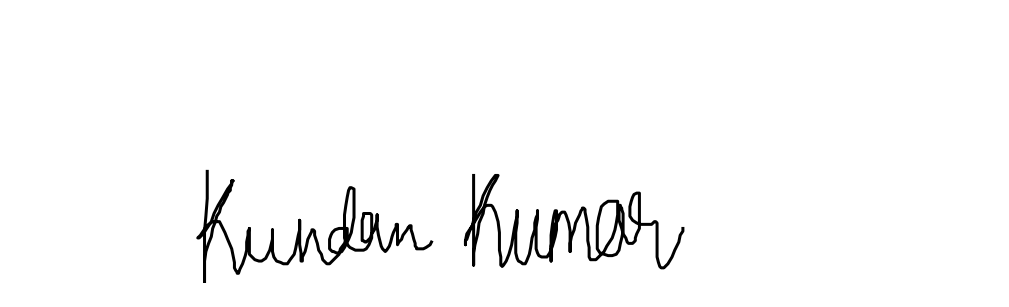

Priming text:  Kundan Kumar
Priming sequence size:  torch.Size([1, 596, 3])
Vocab size:  77
Kundan Kumar hello world  
Generating sequence....
EOS: True
seq_len: 335
Input seq:  Kundan Kumar hello world  
Length of input sequence:  26


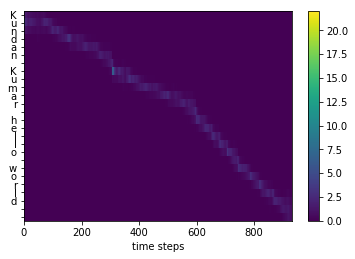

data denormalization...
(1, 932, 3)


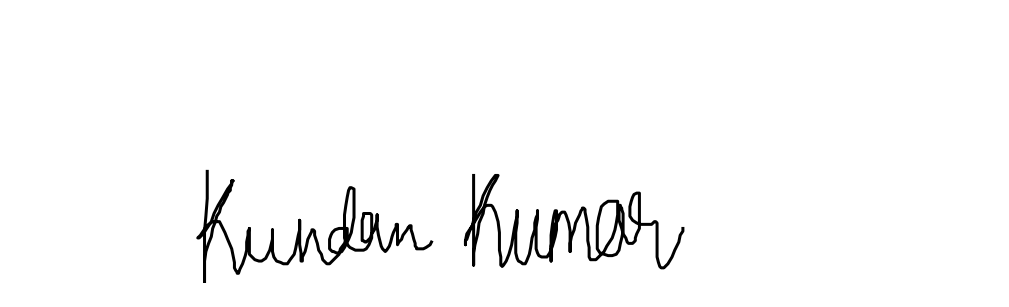

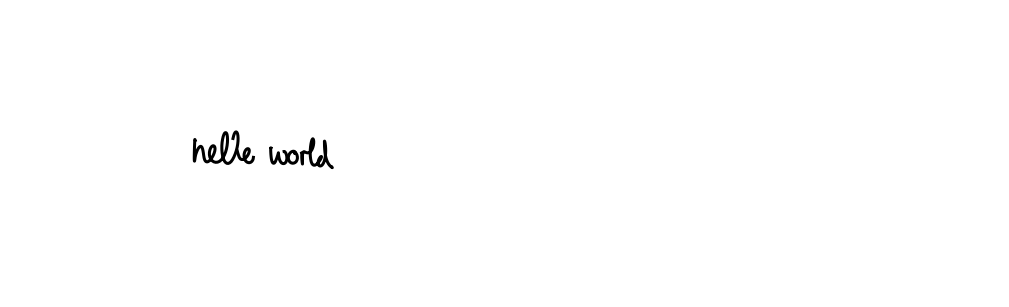

In [4]:
seed = 122 #213
torch.manual_seed(seed)
np.random.seed(seed)
model_path = '../results/best_model_synthesis.pt'

train_dataset = HandwritingDataset(data_path, split='train', text_req=True)

prime = True
bias = 8.
char_seq = "hello world"
is_map = True
file_path = '../app/static/'

style = np.load(file_path + 'style.npy', allow_pickle=True, encoding='bytes').astype(np.float32)
with open(file_path + 'inpText.txt') as file:
    texts = file.read().splitlines()
real_text = texts[0]
print(np.min(style, axis=0))
print(np.max(style, axis=0))
# plot the sequence
plot_stroke(style)
print("Priming text: ", real_text)
mean, std, style = data_normalization(style)
style = torch.from_numpy(style).unsqueeze(0).to(device)
# style = valid_offset_normalization(Global.train_mean, Global.train_std, style[None,:,:])
# style = torch.from_numpy(style).to(device)
print("Priming sequence size: ", style.shape)
ytext = real_text + ' ' + char_seq + "  "

gen_seq, phi = generate_conditional_sequence(
            model_path, char_seq, device, train_dataset.char_to_id,
            train_dataset.idx_to_char, bias, prime, style, real_text, is_map)
if is_map:
    plt.imshow(phi, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.xlabel("time steps")
    plt.yticks(np.arange(phi.shape[0]), list(ytext), rotation='horizontal')
    plt.margins(0.2)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

# denormalize the generated offsets using train set mean and std
print("data denormalization...")
end = style.shape[1]
gen_seq[:,:end] = data_denormalization(mean, std, gen_seq[:, :end])
gen_seq[:,end:] = data_denormalization(Global.train_mean, Global.train_std, gen_seq[:,end:])
# plot the sequence
print(gen_seq.shape)
plot_stroke(gen_seq[0][:end])
plot_stroke(gen_seq[0,end:])

# import os
import pickle
import random
import numpy as np
import svgwrite
from IPython.display import SVG, display


def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 1]) / factor
        y = float(data[i, 2]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=1, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 1]) / factor
        y = float(-data[i, 2]) / factor
        lift_pen = data[i, 0]
        p += command + str(x) + "," + str(y) + " "

    the_color = "blue"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))

tensor([[[       0.0000,      608.5001, -1595411.6250],
         [       0.0000,       11.6354,    12860.2510],
         [       0.0000,       11.6354,    39664.7773],
         ...,
         [       0.0000,       31.5309,    12860.2510],
         [       0.0000,       11.6354,     -542.0118],
         [       1.0000,       11.6354,     -542.0118]]])


[[ 0.0000000e+00  1.1071573e+03 -1.0673537e+07]
 [ 0.0000000e+00  2.1664892e+01  8.6036734e+04]
 [ 0.0000000e+00  2.1664892e+01  2.6536294e+05]
 ...
 [ 0.0000000e+00  5.7847969e+01  8.6036734e+04]
 [ 0.0000000e+00  2.1664892e+01 -3.6263689e+03]
 [ 1.0000000e+00  2.1664892e+01 -3.6263689e+03]]


RuntimeError: libpng signaled error

<Figure size 0.605455x360 with 1 Axes>